In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from sklearn.metrics import roc_curve, roc_auc_score
from scipy.interpolate import interp1d
from IPython.display import display
import pandas as pd
import os
import sys

# brainbox / iblatlas / ONE 관련
from brainbox.io.one import SessionLoader, SpikeSortingLoader
from iblatlas.atlas import AllenAtlas
from one.api import ONE

sys.path.append('VISp_PSTH/v3_def')
from compute_raster import compute_raster
from sub_func import save_file

# 현재 파일 위치로 이동
# os.chdir(os.path.dirname(os.path.abspath(__file__)))

# -----------------------------------------------------------------------------
# 1. AUROC 및 ROC Curve 계산 함수 (Mean ROC 추가)
# -----------------------------------------------------------------------------
from compute_sp import compute_sp
from compute_dp import compute_dp

from plot_sp import plot_sp, plot_sp_transformed, plot_sp_roc
from plot_dp import plot_dp, plot_dp_transformed, plot_dp_roc




In [2]:

# -----------------------------------------------------------------------------
# 2. 데이터 로드 및 전처리
# -----------------------------------------------------------------------------
brain_acronym = 'VISp'
one = ONE()

sessions = one.search(atlas_acronym=brain_acronym, query_type='remote')
sessions = list(sessions)
print(f"Found {len(sessions)} sessions for region: {brain_acronym}")
for i in [44, 45, 68, 68, 68]:
    sessions.pop(i)
print(f"Found {len(sessions)} sessions for region: {brain_acronym}")

data_path = "Z:\ChaeHyeon_Seong"
trials_df_all = pd.DataFrame()

i=1
for eid in sessions:
    print(f"\n=== [Session{i}: {eid}] ==="); i+=1
    session_folder = os.path.join(data_path, eid)
    trials_info = pd.read_csv(os.path.join(session_folder, "trials_info.csv"))
    trials_df_all = pd.concat([trials_df_all, trials_info], ignore_index=True)

# -----------------------------------------------------------------------------
# reaction_time 계산
# -----------------------------------------------------------------------------
reaction_time = trials_df_all['response_times'] - trials_df_all['stimOn_times']
print(f'Average reaction time: {np.mean(reaction_time)}')
left_reaction_time = np.mean(reaction_time[~np.isnan(trials_df_all['contrastLeft'])])
right_reaction_time = np.mean(reaction_time[~np.isnan(trials_df_all['contrastRight'])])
print(f'Average reaction time for stimulus on')
print(f'Left: {left_reaction_time}')
print(f'Right: {right_reaction_time}')

pre_time = 2.0
post_time = 4.0
bin_size = 0.001
times = np.arange(-pre_time, post_time, bin_size)
start_time, end_time = 0, right_reaction_time
start_idx = np.searchsorted(times, start_time)
end_idx = np.searchsorted(times, end_time)

contrast_levels = [0.0625, 0.125, 0.25]
colors = ['r', 'g', 'b']  # Contrast 별 색상


Found 73 sessions for region: VISp
Found 68 sessions for region: VISp

=== [Session1: 5ae68c54-2897-4d3a-8120-426150704385] ===

=== [Session2: 6899a67d-2e53-4215-a52a-c7021b5da5d4] ===

=== [Session3: ca4ecb4c-4b60-4723-9b9e-2c54a6290a53] ===

=== [Session4: 7dd27c2f-9544-448d-918d-be0f9837b0e0] ===

=== [Session5: caa5dddc-9290-4e27-9f5e-575ba3598614] ===

=== [Session6: caa5dddc-9290-4e27-9f5e-575ba3598614] ===

=== [Session7: 642c97ea-fe89-4ec9-8629-5e492ea4019d] ===

=== [Session8: 2584ce3c-db10-4076-89cb-5d313138dd38] ===

=== [Session9: 1dbba733-24a4-4400-9436-53f1bd8428e8] ===

=== [Session10: 0cf6d255-8f2f-463e-84fb-c54bacb79f51] ===

=== [Session11: 6ab9d98c-b1e9-4574-b8fe-b9eec88097e0] ===

=== [Session12: f56194bc-8215-4ae8-bc6a-89781ad8e050] ===

=== [Session13: 5c0c560e-9e1f-45e9-b66e-e4ee7855be84] ===

=== [Session14: 5c0c560e-9e1f-45e9-b66e-e4ee7855be84] ===

=== [Session15: 7cc74598-9c1b-436b-84fa-0bf89f31adf6] ===

=== [Session16: 8a1cf4ef-06e3-4c72-9bc7-e1baa189841b]

In [3]:

# # -----------------------------------------------------------------------------
# clusters = pd.DataFrame()
# mean_fr_values_all = []
# sp_values_all = []
# dp_values_dict_all = {contrast: [] for contrast in [0.0625, 0.125, 0.25]}

# i=1
# for eid in sessions:
#     print(f"\n=== [Session{i}: {eid}] ==="); i+=1
#     session_folder = os.path.join(data_path, eid)
#     trials_df = pd.read_csv(os.path.join(session_folder, "trials_info.csv"))

#     pids, labels = one.eid2pid(eid)

#     for pid, label in zip(pids, labels):
#         print(f"   -> Probe: {pid} ({label})")
#         probe_folder = os.path.join(session_folder, label)

#         # neuron_info = pd.read_csv(os.path.join(probe_folder, "neuron_info.csv"))
#         psth = np.load(os.path.join(probe_folder, "psth.npy"))

#         # mean firing rate 계산
#         mean_fr_values = np.mean(psth[:, :, start_idx:end_idx], axis=(1, 2))
#         mean_fr_values_all.append(mean_fr_values)

#         # SP 계산
#         sp_values, _ = compute_sp(psth, trials_df, start_idx, end_idx)
#         sp_values_all.append(sp_values)

#         # DP 계산 (contrast별)
#         for contrast in [0.0625, 0.125, 0.25]:
#             mask_contrast = (trials_df['contrastRight'] == contrast)
#             dp_values, _ = compute_dp(psth, trials_df, mask_contrast, start_idx, end_idx)
#             dp_values_dict_all[contrast].append(dp_values)


In [4]:

# ----------------------------------------------------------------------------- 
# 모든 세션의 결과를 하나로 결합 
# ----------------------------------------------------------------------------- 
cluster_type = 'good'  # 'all' or 'good'

save_path = f"../result/VISp/SP_DP/all_sessions/SO+{end_time}s/{cluster_type}_clusters"

mean_fr_values_all = np.load(os.path.join(save_path, "mean_fr_values_all.npy"))
sp_values_all = np.load(os.path.join(save_path, "sp_values_all.npy"))
dp_values_dict_all = pd.read_csv(os.path.join(save_path, f"dp_values_dict_all.csv"), index_col=0)
# dict 로 변환
dp_values_dict_all = {float(contrast): dp_values_dict_all[str(contrast)].values for contrast in contrast_levels}


# mean_fr_values_all = np.concatenate(mean_fr_values_all)
# sp_values_all = np.concatenate(sp_values_all)
# dp_values_dict_all = {contrast: np.concatenate(dp_values_dict_all[contrast]) for contrast in dp_values_dict_all}
# # dp_values_dict_all의 type을 확인하기 위해 출력
# print(f"type of dp_values_dict_all: {type(dp_values_dict_all)}")

# save_file(mean_fr_values_all, save_path=save_path, save_title="mean_fr_values_all")
# save_file(sp_values_all, save_path=save_path, save_title="sp_values_all")
# save_file(dp_values_dict_all, save_path=save_path, save_title="dp_values_dict_all")


# 확인용 출력
print(f"Total mean firing rates: {mean_fr_values_all.shape}")
print(f"Total SP values: {sp_values_all.shape}")
for contrast, dp_values in dp_values_dict_all.items(): 
    print(f"Total DP values for contrast {contrast*100}%: {dp_values.shape}")


Total mean firing rates: (1043,)
Total SP values: (1043,)
Total DP values for contrast 6.25%: (1043,)
Total DP values for contrast 12.5%: (1043,)
Total DP values for contrast 25.0%: (1043,)


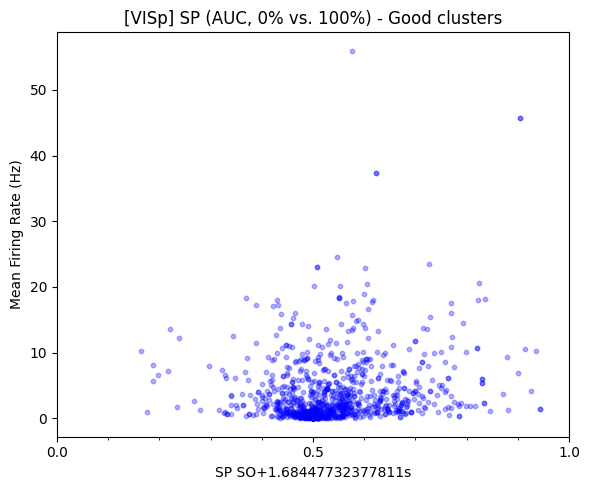

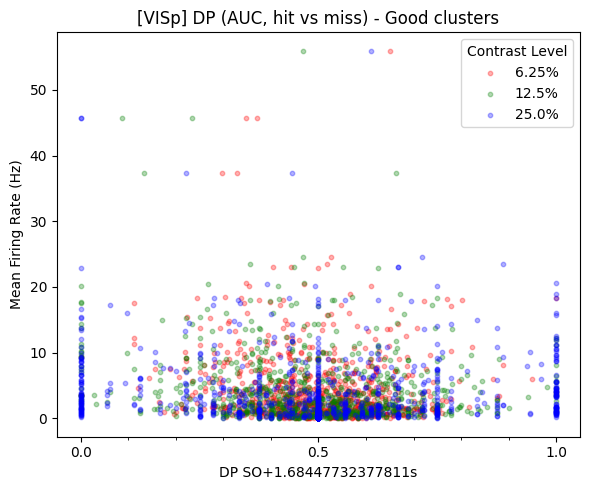

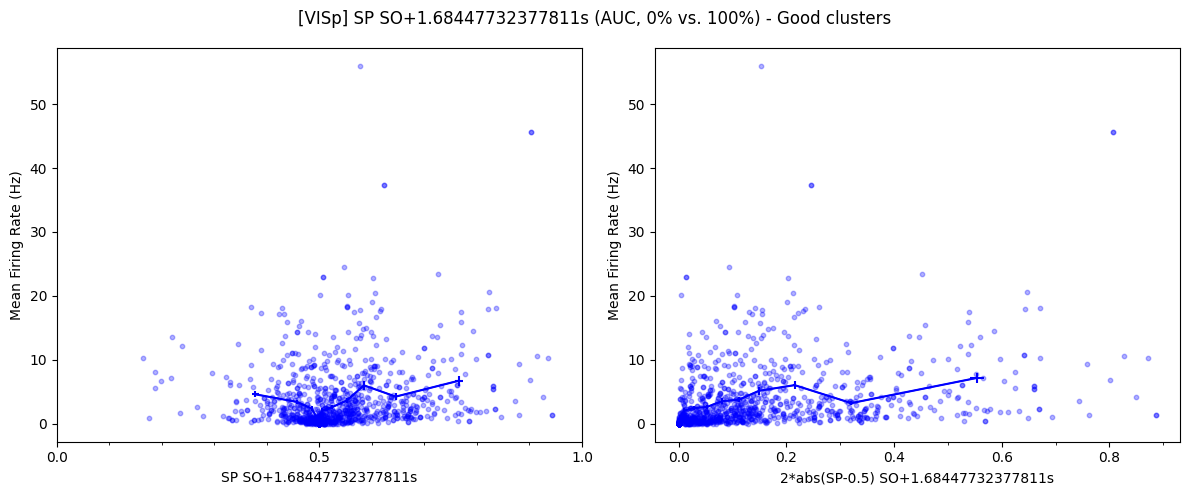

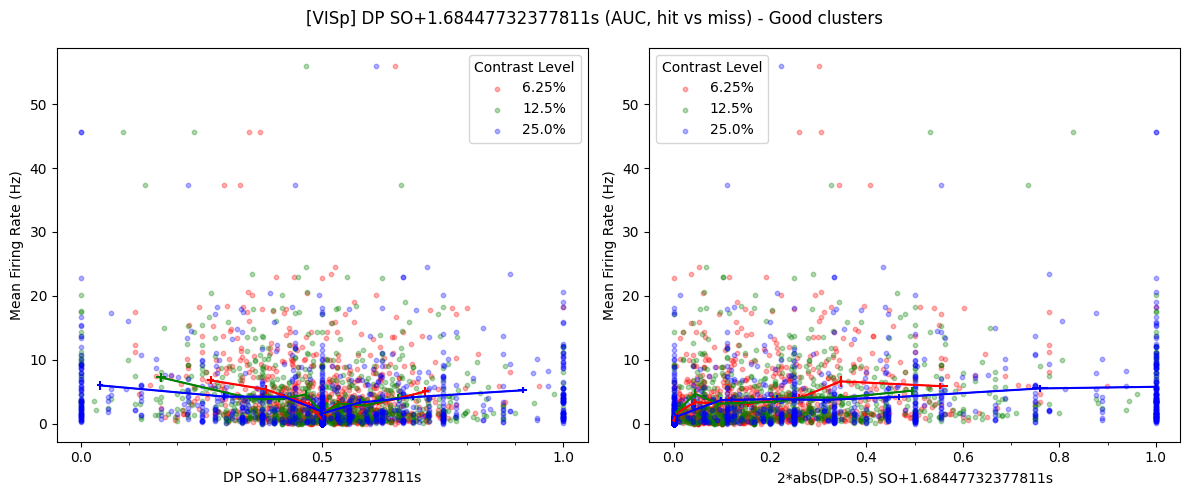

In [5]:

# -----------------------------------------------------------------------------
# 4. 그래프 시각화
# -----------------------------------------------------------------------------
save_path = f"../result/VISp/SP_DP/all_sessions/SO+{end_time}s/{cluster_type}_clusters/SEM_medium"

plot_info_sp = [brain_acronym, cluster_type, end_time]
plot_info_dp = [brain_acronym, cluster_type, end_time, contrast_levels, colors]

plot_sp(sp_values_all, mean_fr_values_all, plot_info_sp, save_path)
plot_dp(dp_values_dict_all, mean_fr_values_all, plot_info_dp, save_path)

# -----------------------------------------------------------------------------
# 4. 그래프 시각화 (원본 vs 변환)
# -----------------------------------------------------------------------------
plot_sp_transformed(sp_values_all, mean_fr_values_all, plot_info_sp, save_path)
plot_dp_transformed(dp_values_dict_all, mean_fr_values_all, plot_info_dp, save_path)

# -----------------------------------------------------------------------------
# 4. 그래프 시각화 (1x2)
# -----------------------------------------------------------------------------
# plot_sp_roc(sp_values, mean_roc_sp, mean_fr_values, plot_info_sp, save_path)
# plot_dp_roc(dp_values_dict, mean_roc_dp_dict, mean_fr_values, plot_info_dp, save_path)

plt.show()

# 아무 키나 누르면 피규어 창이 닫힙니다.
input("Press any key to close the figure...\n")
plt.close()

